<a href="https://colab.research.google.com/github/ykitaguchi77/statistics_for_articles/blob/main/Blepharospasm_sensory_trick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Blepharospasm_sensory_trick**

In [ ]:
# prompt: gdriveをマウント

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Sex_label         Female  Male  Female (%)  Male (%)
Condition                                           
Blepharospasm         23     9        71.9      28.1
Hemifacial spasm      11     6        64.7      35.3
Age (Mann–Whitney U): U = 422.0, p = 0.0017
Sex (Chi‑square): χ² = 0.04, p = 0.8472


/tmp/ipython-input-4-1973009975.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=conditions_order, showfliers=True)


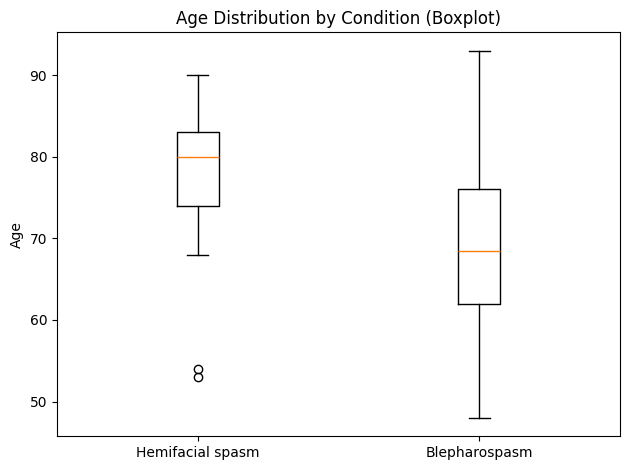

In [ ]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "/content/drive/MyDrive/発表/2025神経眼科学会/知覚トリックの頻度調査.xlsx"
df = pd.read_excel(file_path, sheet_name='Data')

# Filter Type 0 & 1 and ensure required columns
df_filtered = df[['Type', 'Age', 'Sex']].dropna(subset=['Type', 'Age', 'Sex'])
df_filtered = df_filtered[df_filtered['Type'].isin([0, 1])]

# Map to condition and sex labels
condition_map = {0: 'Hemifacial spasm', 1: 'Blepharospasm'}
sex_map = {0: 'Male', 1: 'Female'}
df_filtered['Condition'] = df_filtered['Type'].map(condition_map)
df_filtered['Sex_label'] = df_filtered['Sex'].map(sex_map)

# ------------------------------
# Sex distribution table
# ------------------------------
sex_counts = pd.crosstab(df_filtered['Condition'], df_filtered['Sex_label'])
sex_pct = (sex_counts.div(sex_counts.sum(axis=1), axis=0) * 100).round(1)
sex_table = pd.concat([sex_counts, sex_pct.add_suffix(' (%)')], axis=1)

print(sex_table)

# ------------------------------
# Statistical tests
# ------------------------------
# Age: Mann-Whitney U
ages_hfs = df_filtered[df_filtered['Condition'] == 'Hemifacial spasm']['Age']
ages_bep = df_filtered[df_filtered['Condition'] == 'Blepharospasm']['Age']
u_stat, p_age = stats.mannwhitneyu(ages_hfs, ages_bep, alternative='two-sided')

# Sex: Chi-square test
chi2_stat, chi2_p, _, _ = stats.chi2_contingency(sex_counts)

print(f"Age (Mann–Whitney U): U = {u_stat:.1f}, p = {p_age:.4f}")
print(f"Sex (Chi‑square): χ² = {chi2_stat:.2f}, p = {chi2_p:.4f}")

# Boxplot
plt.figure()
conditions_order = ['Hemifacial spasm', 'Blepharospasm']
box_data = [df_filtered[df_filtered['Condition'] == c]['Age'] for c in conditions_order]
plt.boxplot(box_data, labels=conditions_order, showfliers=True)
plt.ylabel('Age')
plt.title('Age Distribution by Condition (Boxplot)')
plt.tight_layout()
plt.show()


In [ ]:
# Clean column names (strip leading/trailing spaces)
df.columns = df.columns.str.strip()

# --- Filter to Type 1 (Blepharospasm) ---
bleph = df[df['Type'] == 1].copy()
n_total = len(bleph)

# --- Age summary ---
age_stats = bleph['Age'].describe()
age_iqr = age_stats['75%'] - age_stats['25%']
age_summary_df = pd.DataFrame({
    'Count': [int(age_stats['count'])],
    'Mean': [age_stats['mean']],
    'Median': [age_stats['50%']],
    'Std': [age_stats['std']],
    'IQR': [age_iqr]
})
print(age_summary_df)

# --- Sex distribution ---
sex_map = {0: 'Male', 1: 'Female'}
bleph['Sex_label'] = bleph['Sex'].map(sex_map)
sex_counts = bleph['Sex_label'].value_counts(dropna=False)
sex_pct = (sex_counts / n_total * 100).round(1)
sex_df = pd.DataFrame({'Count': sex_counts, 'Percent': sex_pct})
print(sex_df)

# --- Numeric variables summary ---
num_vars = ['Duration', 'Interval', 'Botox_unit']
summary_rows = []
for var in num_vars:
    s = bleph[var].describe()
    summary_rows.append({
        'Variable': var,
        'Count': int(s['count']),
        'Mean': s['mean'],
        'Median': s['50%'],
        'Std': s['std'],
        'IQR': s['75%'] - s['25%']
    })
num_summary_df = pd.DataFrame(summary_rows)
print(num_summary_df)

# --- Categorical variables summary ---
cat_vars = ['Botox_abovebrow', 'Botox_glabellar']
cat_summary_rows = []
for var in cat_vars:
    counts = bleph[var].value_counts(dropna=False)
    pct = (counts / n_total * 100).round(1)
    for category, count in counts.items():
        cat_summary_rows.append({
            'Variable': var,
            'Category': category,
            'Count': count,
            'Percent': pct[category]
        })
cat_summary_df = pd.DataFrame(cat_summary_rows)
print(cat_summary_df)

# --- Sensory trick presence ---
bleph['Sensory_trick_present'] = (
    (bleph['SensoryTrick_temple'] == 1) |
    (bleph['SensoryTrick_subbrow'] == 1)
).astype(float)

sens_counts = bleph['Sensory_trick_present'].value_counts(dropna=False)
sens_pct = (sens_counts / n_total * 100).round(1)
sense_df = pd.DataFrame({'Count': sens_counts, 'Percent': sens_pct})
print(sense_df)

# --- Subset Type 1 (Blepharospasm) ---
bleph = df[df['Type'] == 1].copy()
n_total = len(bleph)

# --- Surgery history flag from "History" column ---
def has_surgery(val):
    if pd.isna(val):
        return 'No'
    # numeric zero (int/float) or string '0'
    if isinstance(val, (int, float)) and val == 0:
        return 'No'
    if isinstance(val, str) and re.fullmatch(r'\s*0\s*', val):
        return 'No'
    return 'Yes'

bleph['Surgery_history'] = bleph['History'].apply(has_surgery)

# --- Surgery history distribution ---
hist_counts = bleph['Surgery_history'].value_counts(dropna=False)
hist_pct = (hist_counts / n_total * 100).round(1)
hist_df = pd.DataFrame({'Count': hist_counts, 'Percent': hist_pct})
print(hist_df)

# --- Numeric summaries by surgery history ---
num_vars = ['Duration', 'Interval']
summary_rows = []
for var in num_vars:
    for grp, grp_df in bleph.groupby('Surgery_history'):
        s = grp_df[var].describe()
        summary_rows.append({
            'Variable': var,
            'Surgery_history': grp,
            'Count': int(s['count']),
            'Mean': s['mean'],
            'Median': s['50%'],
            'Std': s['std'],
            'IQR': s['75%'] - s['25%']
        })
summary_df = pd.DataFrame(summary_rows)
print(summary_df)


   Count      Mean  Median        Std   IQR
0     32  68.03125    68.5  10.923441  14.0
           Count  Percent
Sex_label                
Female        23     71.9
Male           9     28.1
     Variable  Count        Mean  Median        Std      IQR
0    Duration     32  107.500000   110.0  58.151637  114.000
1    Interval     32    3.375000     3.0   1.047270    0.625
2  Botox_unit     32   40.398438    40.0   8.262786   15.000
          Variable  Category  Count  Percent
0  Botox_abovebrow       1.0     22     68.8
1  Botox_abovebrow       0.0     10     31.2
2  Botox_glabellar       1.0     17     53.1
3  Botox_glabellar       0.0     15     46.9
                       Count  Percent
Sensory_trick_present                
1.0                       21     65.6
0.0                       11     34.4
                 Count  Percent
Surgery_history                
No                  20     62.5
Yes                 12     37.5
   Variable Surgery_history  Count        Mean  Median     

In [ ]:
# Subset to Type 1 (Blepharospasm)
bleph = df[df['Type'] == 1].copy()

# Parse Botox_dissatisfaction
def extract_duration(val):
    if pd.isna(val):
        return None
    # Regex to capture number followed by M/m
    match = re.search(r'(\d+(?:\.\d+)?)\s*[Mm]', str(val))
    if match:
        return float(match.group(1))
    return None

bleph['Effect_duration_M'] = bleph['Botox_dissatisfaction'].apply(extract_duration)

# Separate complaints (non-duration text)
def complaint_or_blank(val):
    if pd.isna(val):
        return None
    if extract_duration(val) is not None:
        return None
    # Strip and return text
    return str(val).strip()

bleph['Complaint_text'] = bleph['Botox_dissatisfaction'].apply(complaint_or_blank)

# --- Summary of effect duration ---
duration_series = bleph['Effect_duration_M'].dropna()
duration_stats = duration_series.describe()
duration_stats_df = pd.DataFrame(duration_stats).transpose()
duration_stats_df['IQR'] = duration_stats_df['75%'] - duration_stats_df['25%']
print(duration_stats_df)

# --- Distribution of complaints ---
complaints = bleph['Complaint_text'].dropna()
complaint_counts = complaints.value_counts()
complaint_df = complaint_counts.reset_index()
complaint_df.columns = ['Complaint', 'Count']
print(complaint_df)


                   count      mean       std  min  25%  50%  75%  max  IQR
Effect_duration_M    9.0  1.944444  0.634648  0.5  2.0  2.0  2.5  2.5  0.5
              Complaint  Count
0                     0     11
1                  ちょうど      2
2                   2ヶ月      1
3                 1.5ヶ月      1
4         眼は調子良い、口が調子悪い      1
5             効果ないと訴えあり      1
6     効果に不満、食事時につむってしまう      1
7             あまり効いていない      1
8     効果に不満。眉毛が落ちて開きにくい      1
9                 効果に不満      1
10  2ヶ月ぐらいでまぶしくて開けにくくなる      1
11                   なし      1


In [ ]:
import re
import pandas as pd

# ------- ① 事前処理 -------
bleph = df[df['Type'] == 1].copy()               # Type1 = Blepharospasm
bleph['Botox_dissatisfaction'] = (
    bleph['Botox_dissatisfaction'].astype(str).str.strip()
    .replace({'nan': None})                      # NaN 表示を元に戻す
)

# ------- ② 分類関数 -------
def classify(text: str):
    if text in [None, '', '0', '0.0', '０', 'ちょうど', 'なし']:
        return 0, 0, 1          # effect, duration, none

    # 期間ワード
    duration_pat = re.compile(
        r'\d+\s*(ヶ月?|週|M)|持たない|直前|ぐらい|切れる', re.I)
    # 効果ワード
    effect_pat = re.compile(
        r'効果|効|不満|調子|開けにく|まぶしく|効いていない', re.I)

    dur = bool(duration_pat.search(text))
    eff = bool(effect_pat.search(text))
    none = 0 if (dur or eff) else 1
    return int(eff), int(dur), int(none)

# ------- ③ 適用 -------
bleph[['Effect_related',
       'Duration_related',
       'No_dissatisfaction']] = (
    bleph['Botox_dissatisfaction']
    .apply(lambda x: pd.Series(classify(x)))
)

# ------- ④ 結果確認（任意） -------
# 個別フラグ付き一覧
print(bleph[['Botox_dissatisfaction',
             'Effect_related',
             'Duration_related',
             'No_dissatisfaction']])

# 集計
summary = bleph[['Effect_related',
                 'Duration_related',
                 'No_dissatisfaction']].sum()
print('\n=== Summary ===\n', summary)


   Botox_dissatisfaction  Effect_related  Duration_related  No_dissatisfaction
1                   2.5M               0                 1                   0
3                  1.5ヶ月               0                 1                   0
4                    2ヶ月               0                 1                   0
6                      0               0                 0                   1
8          眼は調子良い、口が調子悪い               1                 0                   0
10                  2.5M               0                 1                   0
11                  0.5M               0                 1                   0
12                  2.5M               0                 1                   0
13                  ちょうど               0                 0                   1
14             効果ないと訴えあり               1                 0                   0
17                     0               0                 0                   1
18                  1.5M               0            

In [ ]:
# Google Drive (必要なら実行)
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import scipy.stats as stats
import re
import statsmodels.formula.api as smf

# -----------------------------
# 1. データ読み込み・前処理
# -----------------------------
file_path = '/content/drive/MyDrive/発表/2025神経眼科学会/知覚トリックの頻度調査.xlsx'
df = pd.read_excel(file_path, sheet_name='Data')
df.columns = df.columns.str.strip()

# Type 1（Blepharospasm）のみ
bleph = df[df['Type'] == 1].copy()

# Sex / Surgery history
bleph['Sex_label'] = bleph['Sex'].map({0: 'Male', 1: 'Female'})
bleph['Sex_female'] = (bleph['Sex_label'] == 'Female').astype(int)

def has_surgery(val):
    if pd.isna(val): return 'No'
    if isinstance(val, (int, float)) and val == 0: return 'No'
    if isinstance(val, str) and re.fullmatch(r'\s*0\s*', val): return 'No'
    return 'Yes'
bleph['Surgery_history'] = bleph['History'].apply(has_surgery)
bleph['Surgery_history_yes'] = (bleph['Surgery_history'] == 'Yes').astype(int)

# Sensory trick 有無
bleph['Sensory_trick_present'] = (
    (bleph['SensoryTrick_temple'] == 1) |
    (bleph['SensoryTrick_subbrow'] == 1)
).astype(int)

# Botox_dissatisfaction 分類
bleph['Botox_dissatisfaction'] = (
    bleph['Botox_dissatisfaction'].astype(str).str.strip()
    .replace({'nan': None})
)

def classify(text):
    if text in [None, '', '0', '0.0', '０', 'ちょうど', 'なし']:
        return pd.Series({'Effect_related':0,'Duration_related':0,'No_dissatisfaction':1})
    dur_p = re.search(r'\d+\s*(?:ヶ月?|週|M)|持たない|直前|ぐらい|切れる', text, re.I)
    eff_p = re.search(r'効果|効|不満|調子|開けにく|まぶしく|効いていない', text, re.I)
    dur = int(bool(dur_p))
    eff = int(bool(eff_p))
    none = 0 if (dur or eff) else 1
    return pd.Series({'Effect_related':eff,'Duration_related':dur,'No_dissatisfaction':none})

bleph[['Effect_related','Duration_related','No_dissatisfaction']] = (
    bleph['Botox_dissatisfaction'].apply(classify)
)

# 非数値カテゴリを int に
for v in ['Botox_abovebrow', 'Botox_glabellar']:
    bleph[v] = bleph[v].astype(float).astype('Int64').fillna(0).astype(int)

# -----------------------------
# 2. 群間比較
# -----------------------------
num_vars = ['Age','Duration','Interval','Botox_unit']
cat_vars = ['Sex_female','Surgery_history_yes',
            'Botox_abovebrow','Botox_glabellar',
            'Effect_related','Duration_related','No_dissatisfaction']

results = []

# 数値
for var in num_vars:
    g1 = bleph.loc[bleph['Sensory_trick_present']==1, var].dropna()
    g0 = bleph.loc[bleph['Sensory_trick_present']==0, var].dropna()
    med1, med0 = g1.median(), g0.median()
    u, p = stats.mannwhitneyu(g1, g0, alternative='two-sided')
    results.append({'Variable':var,'Type':'Numeric',
                    'Median_with':med1,'Median_without':med0,
                    'Effect_size':med1-med0,'P_value':p})

# カテゴリ
for var in cat_vars:
    tab = pd.crosstab(bleph['Sensory_trick_present'], bleph[var])
    # 列不足回避
    for col in [0,1]:
        if col not in tab.columns: tab[col] = 0
    tab = tab[[0,1]]
    p = stats.fisher_exact(tab)[1] if (tab.values<5).any() else stats.chi2_contingency(tab)[1]
    or_ = ((tab.loc[1,1]*tab.loc[0,0]) / (tab.loc[1,0]*tab.loc[0,1]+1e-9))
    prop1 = tab.loc[1,1]/tab.loc[1].sum()
    prop0 = tab.loc[0,1]/tab.loc[0].sum()
    results.append({'Variable':var,'Type':'Categorical',
                    'Median_with':prop1,'Median_without':prop0,
                    'Effect_size':or_,'P_value':p})

summary_df = pd.DataFrame(results).round(4)
print('\n=== Group Comparison ===')
print(summary_df.to_string(index=False))

# -----------------------------
# 3. 単変量ロジスティック回帰
# -----------------------------
logit_rows = []
for var in num_vars + cat_vars:
    formula = f'Sensory_trick_present ~ {var}'
    try:
        model = smf.logit(formula, data=bleph).fit(disp=False)
        or_ = np.exp(model.params[1])
        ci_low, ci_high = np.exp(model.conf_int().loc[var])
        p = model.pvalues[1]
        logit_rows.append({'Variable':var,'OR':round(or_,2),
                           'CI_low':round(ci_low,2),'CI_high':round(ci_high,2),
                           'P_value':round(p,4)})
    except Exception as e:
        print(f'Skipped {var}: {e}')

logit_df = pd.DataFrame(logit_rows)
print('\n=== Univariate Logistic Regression ===')
print(logit_df.to_string(index=False))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== Group Comparison ===
           Variable        Type  Median_with  Median_without  Effect_size  P_value
                Age     Numeric      69.0000         67.0000       2.0000   0.9050
           Duration     Numeric      96.0000        156.0000     -60.0000   0.2901
           Interval     Numeric       3.0000          3.0000       0.0000   0.4825
         Botox_unit     Numeric      40.0000         40.0000       0.0000   0.9518
         Sex_female Categorical       0.6190          0.9091       0.1625   0.1148
Surgery_history_yes Categorical       0.4762          0.1818       4.0909   0.1389
    Botox_abovebrow Categorical       0.7143          0.6364       1.4286   0.7026
    Botox_glabellar Categorical       0.6190          0.3636       2.8437   0.2662
     Effect_related Categorical       0.2857          0.1818       1.8000   0.6808
   Duration_rel

/tmp/ipython-input-9-2549681310.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  or_ = np.exp(model.params[1])
/tmp/ipython-input-9-2549681310.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = model.pvalues[1]
/tmp/ipython-input-9-2549681310.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  or_ = np.exp(model.params[1])
/tmp/ipython-input-9-2549681310.py:112: FutureWarning: Series.__getitem__ treating keys as positi


=== Contingency Table ===
                  Trick (–)  Trick (+)
Not dissatisfied          6          8
Dissatisfied              5         13


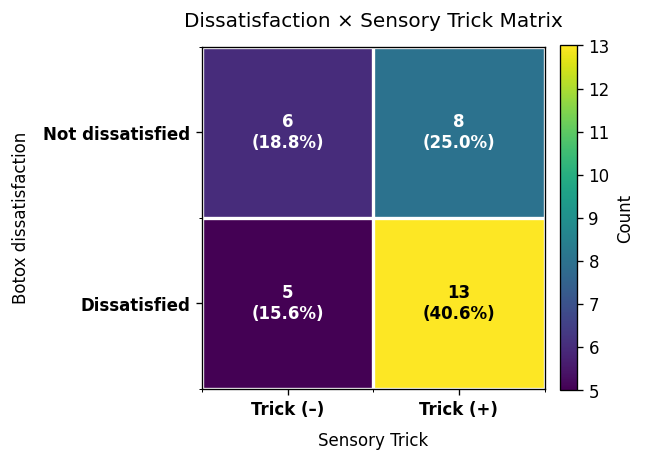

In [ ]:
# =========================================================
# 眼瞼痙攣：不満（期間or効果）× 知覚トリック有無 2×2 マトリックス
# 　▶︎ 集計結果（DataFrame）も表示
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# 1) 不満フラグ（Effect または Duration が 1 なら「不満あり」）
bleph['Dissatisfied'] = (
    (bleph['Effect_related'] == 1) |
    (bleph['Duration_related'] == 1)
).astype(int)

# 2) クロス集計（行：不満なし/あり，列：トリックなし/あり）
mat_counts = (
    pd.crosstab(bleph['Dissatisfied'],
                bleph['Sensory_trick_present'])
      .reindex(index=[0, 1], columns=[0, 1], fill_value=0)
)
mat_counts.index = ['Not dissatisfied', 'Dissatisfied']
mat_counts.columns = ['Trick (–)', 'Trick (+)']

# ----------------------------
# ▼ DataFrame をそのまま表示
# ----------------------------
print('\n=== Contingency Table ===')
print(mat_counts)          # Colab なら `display(mat_counts)` でも OK

# ----------------------------
# ▼ ヒートマップ（上で作成したもの）
# ----------------------------
cmap = mpl.colormaps['viridis']
fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
im = ax.imshow(mat_counts.values, cmap=cmap)

ax.set_xticks([0, 1]); ax.set_xticklabels(mat_counts.columns, fontweight='semibold')
ax.set_yticks([0, 1]); ax.set_yticklabels(mat_counts.index, fontweight='semibold')

total = mat_counts.values.sum()
norm = mpl.colors.Normalize(vmin=mat_counts.values.min(),
                            vmax=mat_counts.values.max())
for i in range(mat_counts.shape[0]):
    for j in range(mat_counts.shape[1]):
        cnt = mat_counts.iat[i, j]
        pct = cnt / total * 100
        bg = cmap(norm(cnt))
        lum = 0.299*bg[0] + 0.587*bg[1] + 0.114*bg[2]
        ax.text(j, i, f'{cnt}\n({pct:.1f}%)',
                ha='center', va='center',
                color=('black' if lum > 0.55 else 'white'),
                fontweight='bold')

ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
ax.grid(which='minor', color='w', linewidth=2)

ax.set_title('Dissatisfaction × Sensory Trick Matrix', pad=12, fontsize=12)
ax.set_xlabel('Sensory Trick', labelpad=8)
ax.set_ylabel('Botox dissatisfaction', labelpad=8)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Count', rotation=90)

plt.tight_layout()
plt.show()
